<h1><b><i>&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; German Traffic Sign Detection and Recognition</i></b></h1> 

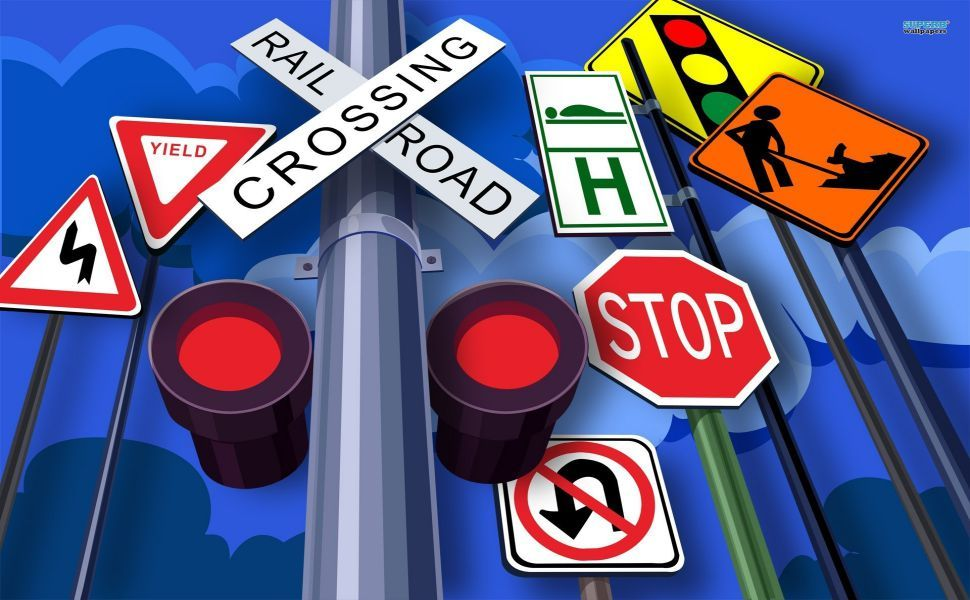

In [0]:
from IPython.display import Image
Image('/content/TrafficSignal.jpg', width=1200)

# 1. Business/ Real-world constraints :

## 1.1. Problem Statement :

<p>
• Traffic signs are an integral part of our road infrastructure. Without such useful signs, 
we would most likely be faced with more accidents, as drivers would not be given critical 
feedback on how fast they could safely go, or informed about road works, sharp turn, or 
school crossings ahead.
<br><br>
• Naturally, autonomous vehicles must also abide by road legislation and therefore recognize and understand traffic signs.
<br><br>
• The German Traffic Sign Benchmark is a multi-class, single-image classification challenge held 
at the International Joint Conference on Neural Networks (IJCNN) 2011.
</p>

## 1.2. Objectives and constraints :

• Each traffic sign should be correctly identified. Hence, multi-class log-loss should be improved.
<br><br>
• Also, time is a major constraint here because a delay of even a second can be a matter of life and death.<br>

## 1.3. Useful References :

• <a href="http://benchmark.ini.rub.de/?section=home&subsection=news">INI Benchmark Website</a>
<br><br>
• <a href="https://cg.cs.tsinghua.edu.cn/traffic-sign/">Traffic sign detection and classification in the wild</a>
<br><br>
• <a href="https://www.kaggle.com/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign">Kaggle page to download the dataset</a>
<br><br>

• <a href="https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html">Building a very powerful image classification model with very little data</a>
<br><br>

## Downloading dataset from kaggle and storing it in temporary memory of colab :

In [1]:
#Importing essential libraries
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from tqdm import tqdm
import random
import math
import cv2
import os
import shutil
from google.colab import files
import pathlib

#Tensorflow stable version
%tensorflow_version 2.1.0
import tensorflow as tf
tf.compat.v1.enable_eager_execution()
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.activations import relu, softmax
from tensorflow.keras.initializers import he_normal, zeros, glorot_normal, RandomNormal
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.regularizers import l1, l2, l1_l2

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.1.0`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#Fixing python random seed
random.seed(42)
#fixing numpy random seed
np.random.seed(21)
#fixing tensorflow random seed
tf.random.set_seed(42)

In [0]:
def download_dataset_from_kaggle() :
  '''
  This function downloads the German traffic sign
  dataset from kaggle and stores it in temporary
  session memory of google colab and unzips it.
  '''
  #Upload the kaggle api token
  print('Please upload the kaggle api token :')
  files.upload() #this will prompt you to update the json
  !pip install -q kaggle
  !mkdir -p ~/.kaggle
  !cp kaggle.json ~/.kaggle/
  !ls ~/.kaggle
  !chmod 600 /root/.kaggle/kaggle.json  # set permission

  #Downloading and unzipping the dataset
  !kaggle datasets download -d meowmeowmeowmeowmeow/gtsrb-german-traffic-sign
  !unzip -q /content/gtsrb-german-traffic-sign.zip -d Data

In [5]:
download_dataset_from_kaggle()

Please upload the kaggle api token :


Saving kaggle.json to kaggle.json
kaggle.json
 97% 593M/612M [00:03<00:00, 208MB/s]
100% 612M/612M [00:03<00:00, 193MB/s]


# 2. Dividing train data into trian and validation sets :

*   In the dataset, we only have train and test data folders. Test data should not be used while training.
*   Hence, i will divide train data into train and validation data such that in validation set, each class will have 25% of images of the same class in train set.

In [6]:
#Run this only once
#Creating validation directory
val_dir = "/content/Data/Validation"
os.mkdir(val_dir)

n_classes = 43
train_dir = "/content/Data/Train{0}"

#Moving files from train to validation directory
for n in tqdm(range(n_classes)) :
  path = os.path.join(val_dir, str(n))
  os.mkdir(path)
  src_path = train_dir.format('/' + str(n))
  files = os.listdir(src_path)
  rand_idx = random.sample(range(len(files)), math.ceil(len(files)/4))
  for idx in rand_idx :
    src = src_path + "/" + files[idx]
    shutil.move(src, path)

100%|██████████| 43/43 [00:00<00:00, 95.40it/s]


In [0]:
#Setting up variables
IMG_WIDTH = 30
IMG_HEIGHT = 30
N_CHANNELS = 3
BATCH_SIZE = 32
N_EPOCHS = 200
VAL_BATCH_SIZE = 32
CLASS_NAMES = list(range(43))
N_CLASSES = 43
train_path = "/content/Data/Train"         #Train dataset path
val_path = "/content/Data/Validation"      #Validation dataset path

# 3. Input pipeline :

In [0]:
#Path to train and validation datasets
data_root_train = pathlib.Path(train_path)
data_root_val = pathlib.Path(val_path)

#Getting paths to all the images in train and validation sets
all_image_paths_train = list(data_root_train.glob('*/*'))
all_image_paths_train = [str(path) for path in all_image_paths_train]

all_image_paths_val = list(data_root_val.glob('*/*'))
all_image_paths_val = [str(path) for path in all_image_paths_val]

#Counting number of images in each sets
image_count_train = len(all_image_paths_train)
image_count_val = len(all_image_paths_val)

In [0]:
#Extracting labels for each image
label_names_train = sorted(int(item.name) for item in data_root_train.glob('*/') if item.is_dir())
label_names_val = sorted(int(item.name) for item in data_root_val.glob('*/') if item.is_dir())
label_to_index_train = dict((name, index) for index,name in enumerate(label_names_train))
label_to_index_val = dict((name, index) for index,name in enumerate(label_names_val))
all_image_labels_train = [label_to_index_train[int(pathlib.Path(path).parent.name)] for path in all_image_paths_train]
all_image_labels_val = [label_to_index_val[int(pathlib.Path(path).parent.name)] for path in all_image_paths_val]

In [0]:
df_train = pd.read_csv("/content/Data/Train.csv")
for idx, row in df_train.iterrows() :
  w = row['Width']
  h = row['Height']
  if w > IMG_WIDTH :
    diff = w-IMG_WIDTH
    df_train.iloc[idx, 4] = df_train.iloc[idx]['Roi.X2'] - diff
  else :
    diff = IMG_WIDTH-w
    df_train.iloc[idx, 4] = df_train.iloc[idx]['Roi.X2'] + diff
  if h > IMG_HEIGHT :
    diff = h - IMG_HEIGHT
    df_train.iloc[idx, 5] = df_train.iloc[idx]['Roi.Y2'] - diff
  else :
    diff = IMG_HEIGHT - h
    df_train.iloc[idx, 5] = df_train.iloc[idx]['Roi.Y2'] + diff

In [11]:
train_idx_list = []
val_idx_list = []
for path_tr in tqdm(all_image_paths_train) :
  train_idx_list.append(df_train[df_train['Path'] == path_tr[14 : ]].index[0])
for path_val in tqdm(all_image_paths_val) :
  path_val = "Train/" + path_val[25:]
  val_idx_list.append(df_train[df_train['Path'] == path_val].index[0])
new_df_train = pd.DataFrame()
new_df_val = pd.DataFrame()
new_df_train = new_df_train.append(df_train.iloc[train_idx_list], ignore_index = True)
new_df_val = new_df_val.append(df_train.iloc[val_idx_list], ignore_index = True)
new_df_train = new_df_train.drop(['Height', 'Width', 'ClassId', 'Path'], axis = 1)
new_df_val = new_df_val.drop(['Height', 'Width', 'ClassId', 'Path'], axis = 1)

100%|██████████| 9812/9812 [00:25<00:00, 380.73it/s]


In [0]:
def tfdata_generator(images, labels, df, is_training, batch_size=32):
  '''Construct a data generator using tf.Dataset'''
  def parse_function(filename, labels, df):
    '''Function to preprocess the images'''
    #reading path 
    image_string = tf.io.read_file(filename)
    #decoding image
    image = tf.image.decode_png(image_string, channels=N_CHANNELS)
    # This will convert to float values in [0, 1]
    image = tf.image.convert_image_dtype(image, tf.float32)
    #Adjusting contrast and brightness of the image
    if tf.math.reduce_mean(image) < 0.3 :
      image = tf.image.adjust_contrast(image, 5)
      image = tf.image.adjust_brightness(image, 0.2)
    #resize the image
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH], method="nearest", preserve_aspect_ratio=False)
    image = image/255.0
    #one hot coding for label
    #y = tf.one_hot(tf.cast(label, tf.uint8), N_CLASSES)
    return image, {"classification" : labels, "regression" : df}
  ##creating a dataset from tensorslices
  dataset = tf.data.Dataset.from_tensor_slices((images, labels, df))
  if is_training:
    dataset = dataset.shuffle(30000)  # depends on sample size
  # Transform and batch data at the same time
  dataset = dataset.map(parse_function, num_parallel_calls = tf.data.experimental.AUTOTUNE)
  dataset = dataset.repeat()
  dataset = dataset.batch(batch_size)
  #prefetch the data into CPU/GPU
  dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
  return dataset

In [0]:
tf_image_generator_train = tfdata_generator(all_image_paths_train, all_image_labels_train, new_df_train, is_training=True, batch_size=32)
tf_image_generator_val = tfdata_generator(all_image_paths_val, all_image_labels_val, new_df_val, is_training=False, batch_size=32)

In [0]:
steps_per_epoch_train = np.ceil(len(all_image_paths_train)/BATCH_SIZE)
steps_per_epoch_val = np.ceil(len(all_image_paths_val)/BATCH_SIZE)

# 4. Model Definition :

In [0]:
class Sharpen(tf.keras.layers.Layer):
  """
  Sharpen layer sharpens the edges of the image.
  """
    def __init__(self, num_outputs) :
        super(Sharpen, self).__init__()
        self.num_outputs = num_outputs

    def build(self, input_shape) :
        self.kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
        self.kernel = tf.expand_dims(self.kernel, 0)
        self.kernel = tf.expand_dims(self.kernel, 0)
        self.kernel = tf.cast(self.kernel, tf.float32)

    def call(self, input_) :
        return tf.nn.conv2d(input_, self.kernel, strides=[1, 1, 1, 1], padding='SAME')

In [0]:
def get_model() :
  #Input layer
  input_layer = Input(shape=(IMG_HEIGHT, IMG_WIDTH, N_CHANNELS, ), name="input_layer", dtype='float32')
  #Sharpen Layer to sharpen the edges of the image.
  sharp = Sharpen(num_outputs=(IMG_HEIGHT, IMG_WIDTH, N_CHANNELS, ))(input_layer)
  #Convolution, maxpool and dropout layers
  conv_1 = Conv2D(filters=32, kernel_size=(5,5), activation=relu,
                  kernel_initializer=he_normal(seed=54), bias_initializer=zeros(),
                  name="first_convolutional_layer") (sharp)
  conv_2 = Conv2D(filters=64, kernel_size=(3,3), activation=relu,
                  kernel_initializer=he_normal(seed=55), bias_initializer=zeros(),
                  name="second_convolutional_layer") (conv_1)                  
  maxpool_1 = MaxPool2D(pool_size=(2,2), name = "first_maxpool_layer")(conv_2)
  dr1 = Dropout(0.25)(maxpool_1)
  conv_3 = Conv2D(filters=64, kernel_size=(3,3), activation=relu,
                  kernel_initializer=he_normal(seed=56), bias_initializer=zeros(),
                  name="third_convolutional_layer") (dr1)
  maxpool_2 = MaxPool2D(pool_size=(2,2), name = "second_maxpool_layer")(conv_3)
  dr2 = Dropout(0.25)(maxpool_2) 
  flat = Flatten(name="flatten_layer")(dr2)

  #Fully connected layers
  d1 = Dense(units=256, activation=relu, kernel_initializer=he_normal(seed=45),
             bias_initializer=zeros(), name="first_dense_layer_classification", kernel_regularizer = l2(0.001))(flat)
  dr3 = Dropout(0.5)(d1)
  
  classification = Dense(units = 43, activation=None, name="classification",  kernel_regularizer = l2(0.0001))(dr3)
  
  regression = Dense(units = 4, activation = 'linear', name = "regression", 
                     kernel_initializer=RandomNormal(seed=43), kernel_regularizer = l2(0.1))(dr3)
  #Model
  model = Model(inputs = input_layer, outputs = [classification, regression])
  model.summary()
  return model

In [17]:
model = get_model()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 30, 30, 3)]  0                                            
__________________________________________________________________________________________________
sharpen (Sharpen)               (None, 30, 30, 3)    0           input_layer[0][0]                
__________________________________________________________________________________________________
first_convolutional_layer (Conv (None, 26, 26, 32)   2432        sharpen[0][0]                    
__________________________________________________________________________________________________
second_convolutional_layer (Con (None, 24, 24, 64)   18496       first_convolutional_layer[0][0]  
______________________________________________________________________________________________

In [0]:
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import f1_score, precision_score, recall_score
class Metrics(Callback) :
  def __init__(self, validation_data_generator) :
    self.validation_data_generator = validation_data_generator

  def on_train_begin(self, logs={}) :
    '''
    This function initializes lists to store AUC and Micro F1 scores
    '''
    self.val_f1s = []
    self.val_precisions = []
    self.val_recalls = []
    self.batches = self.validation_data_generator.as_numpy_iterator()

  def on_epoch_end(self, epoch, logs = {}) :
    '''
    This function calculates the micro f1 and auc scores
    at the end of each epochs
    '''
    current_batch = self.batches.next()
    images = current_batch[0]
    labels = current_batch[1]
    labels = labels["classification"]
    labels = np.array(labels)
    pred = self.model.predict(images)
    pred = pred[0]
    val_predict = (np.asarray(pred)).round()
    idx = np.argmax(val_predict, axis=-1)
    a = np.zeros( val_predict.shape )
    a[ np.arange(a.shape[0]), idx] = 1
    val_predict = [np.where(r==1)[0][0] for r in a]
    val_predict = np.array(val_predict)
    val_targ = labels
    _val_f1 = f1_score(val_targ, val_predict, average = 'weighted')
    _val_precision = precision_score(val_targ, val_predict, average='weighted')
    _val_recall = recall_score(val_targ, val_predict, average='weighted')
    print("\nEpoch : {0} -  Precision_Score : {1:.2f} - Recall_Score : {2:.2f} - F1_Score : {3:.2f}\n".format(epoch, _val_precision, _val_recall, _val_f1))
    self.val_f1s.append(_val_f1)
    self.val_precisions.append(_val_precision)
    self.val_recalls.append(_val_recall)
    return

In [19]:
from keras import backend as K
def r2_keras(y_true, y_pred):
  SS_res =  K.sum(K.square(y_true - y_pred)) 
  SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
  return ( 1 - SS_res/(SS_tot + K.epsilon()) )

loss = SparseCategoricalCrossentropy(from_logits=True)

model.compile(optimizer="adam", loss = {"classification" : loss, "regression" : "mse"}, 
              metrics={"classification" : "acc", "regression" : r2_keras}, loss_weights = {"classification" : 5, "regression" : 1})

Using TensorFlow backend.


In [0]:
#Callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import f1_score, precision_score, recall_score, auc
import datetime
import time
%load_ext tensorboard
log_dir="/content/drive/My Drive/CaseStudy2/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
NAME = "TrafficSignRecog-first-cut-{0}".format(int(time.time()))
save_best_model = ModelCheckpoint(filepath='/content/drive/My Drive/CaseStudy2/best_models/{0}'.format(NAME), monitor='val_loss',
                                  save_best_only = True, mode = 'min', save_freq = 'epoch')
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True,
                                   write_images = True)
early_stop = EarlyStopping(monitor='loss', min_delta=0.0001, patience=5)
metrics = Metrics(tf_image_generator_val)

In [0]:
history = model.fit_generator(
    generator = tf_image_generator_train, steps_per_epoch = steps_per_epoch_train, #train batch size
    epochs = N_EPOCHS,
    validation_data = tf_image_generator_val, validation_steps = steps_per_epoch_val, #val batch size
    callbacks = [save_best_model, tensorboard_callback, metrics, early_stop]
)

In [0]:
model.save_weights("/content/drive/My Drive/CaseStudy2/BestScoreTillNow.h5")

#Predictions on test data :

In [0]:
test_df = pd.read_csv('/content/Data/Test.csv')
for idx, row in test_df.iterrows() :
  w = row['Width']
  h = row['Height']
  if w > IMG_WIDTH :
    diff = w-IMG_WIDTH
    test_df.iloc[idx, 4] = test_df.iloc[idx]['Roi.X2'] - diff
  else :
    diff = IMG_WIDTH-w
    test_df.iloc[idx, 4] = test_df.iloc[idx]['Roi.X2'] + diff
  if h > IMG_HEIGHT :
    diff = h - IMG_HEIGHT
    test_df.iloc[idx, 5] = test_df.iloc[idx]['Roi.Y2'] - diff
  else :
    diff = IMG_HEIGHT - h
    test_df.iloc[idx, 5] = test_df.iloc[idx]['Roi.Y2'] + diff

In [0]:
def evaluate_test_images(path, model) :
  labels = []
  bbox = []
  all_imgs = os.listdir(path)
  all_imgs.sort()
  for img in tqdm(all_imgs) :
    if '.png' in img :
      image_string = tf.io.read_file(path + '/' + img)
      image = tf.image.decode_png(image_string, channels=N_CHANNELS)
      image = tf.image.convert_image_dtype(image, tf.float32)
      if tf.math.reduce_mean(image) < 0.3 :
        image = tf.image.adjust_contrast(image, 5)
        image = tf.image.adjust_brightness(image, 0.2)
      image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH], method="nearest", preserve_aspect_ratio=False)
      image = image/255.0
      image = np.expand_dims(image, axis=0)
      pred = model.predict(image)
      labels.append(np.argmax(pred[0][0]))
      bbox.append(pred[1][0])
  return labels, bbox

In [0]:
model.load_weights('/content/drive/My Drive/CaseStudy2/BestScoreTillNow.h5')
model.compile()

In [24]:
test_path = "/content/Data/Test"
labels, bbox = evaluate_test_images(test_path, model)

100%|██████████| 12631/12631 [06:53<00:00, 30.51it/s]


In [0]:
from sklearn.metrics import f1_score, mean_squared_error, precision_score, recall_score
test_precision = precision_score(test_df['ClassId'], labels, average='weighted')
test_recall = recall_score(test_df['ClassId'], labels, average='weighted')
test_f1_score = f1_score(test_df['ClassId'], labels, average = 'weighted')
test_mse = mean_squared_error(test_df.iloc[:, 2:6], bbox)

In [26]:
print("Test Precision : {0:.2f}".format(test_precision))
print("Test Recall : {0:.2f}".format(test_recall))
print("Test f1-score : {0:.2f}".format(test_f1_score))
print("Test Mean squared error : {0:.2f}".format(test_mse))

Test Precision : 0.98
Test Recall : 0.98
Test f1-score : 0.98
Test Mean squared error : 1.27


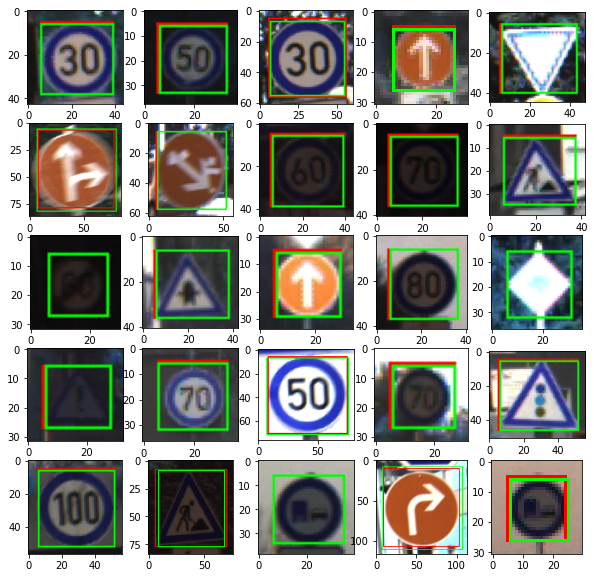

In [106]:
#Plotting some correctly classified images :
import image
import matplotlib.pyplot as plt
import math
test_df = pd.read_csv('/content/Data/Test.csv')
test_path = "/content/Data/"
fig, ax = plt.subplots(5, 5)
fig.set_size_inches((10, 10))
cnt = 0
i = 0
j = 0
while cnt < 25 :
  idx = random.randint(0, test_df.shape[0])
  if test_df.iloc[idx]['ClassId'] == labels[idx] :
    x1, y1, x2, y2 = test_df.iloc[idx, 2:6]
    img = cv2.imread(test_path + test_df.iloc[idx]['Path'])
    height = img.shape[0]
    width = img.shape[1]
    px1, py1, px2, py2 = bbox[idx][0], bbox[idx][1], bbox[idx][2], bbox[idx][3]
    if width > IMG_WIDTH :
      diff = width - IMG_WIDTH
      px2 += diff
    elif width < IMG_WIDTH :
      px2 -= diff
    else :
      pass
    if height > IMG_HEIGHT :
      diff = height - IMG_HEIGHT
      py2 += diff
    elif height < IMG_HEIGHT :
      py2 -= diff
    else :
      pass
    img = cv2.rectangle(img, (x1, y1), (x2, y2), (255,0,0), 1) #Actual bounding box (Red)
    img = cv2.rectangle(img, (math.ceil(px1), math.ceil(py1)), (math.ceil(px2), math.ceil(py2)), (0,255,0), 1) #predicted bounding box (Green)
    ax[i][j].imshow(img)
    j+=1
    if j == 5 :
      i+=1
      j = 0
    cnt+=1
plt.show()

## Observation :


*   The weighted F1-Score for image classification is 0.98.
*   Mean Squared Error is 1.27.
*   From above plotted images, we can see that both the actual bounding boxes as well as the predicted ones almost perfectly overlaps.



## Misclassification analysis :

In [65]:
misclassified_images = []
cnt = 0
class_labels_misclassified = []
for itr in range(len(labels)) :
  if labels[itr] != test_df.iloc[itr]['ClassId'] :
    cnt+=1
    misclassified_images.append(test_df.iloc[itr]['Path'])
    class_labels_misclassified.append(test_df.iloc[itr]['ClassId'])

print("Out of {0} images, {1} are misclassified.".format(test_df.shape[0], cnt))
print("Percentage of misclassified images : {0:.2f}%".format((cnt/test_df.shape[0])*100))

Out of 12630 images, 308 are misclassified.
Percentage of misclassified images : 2.44%


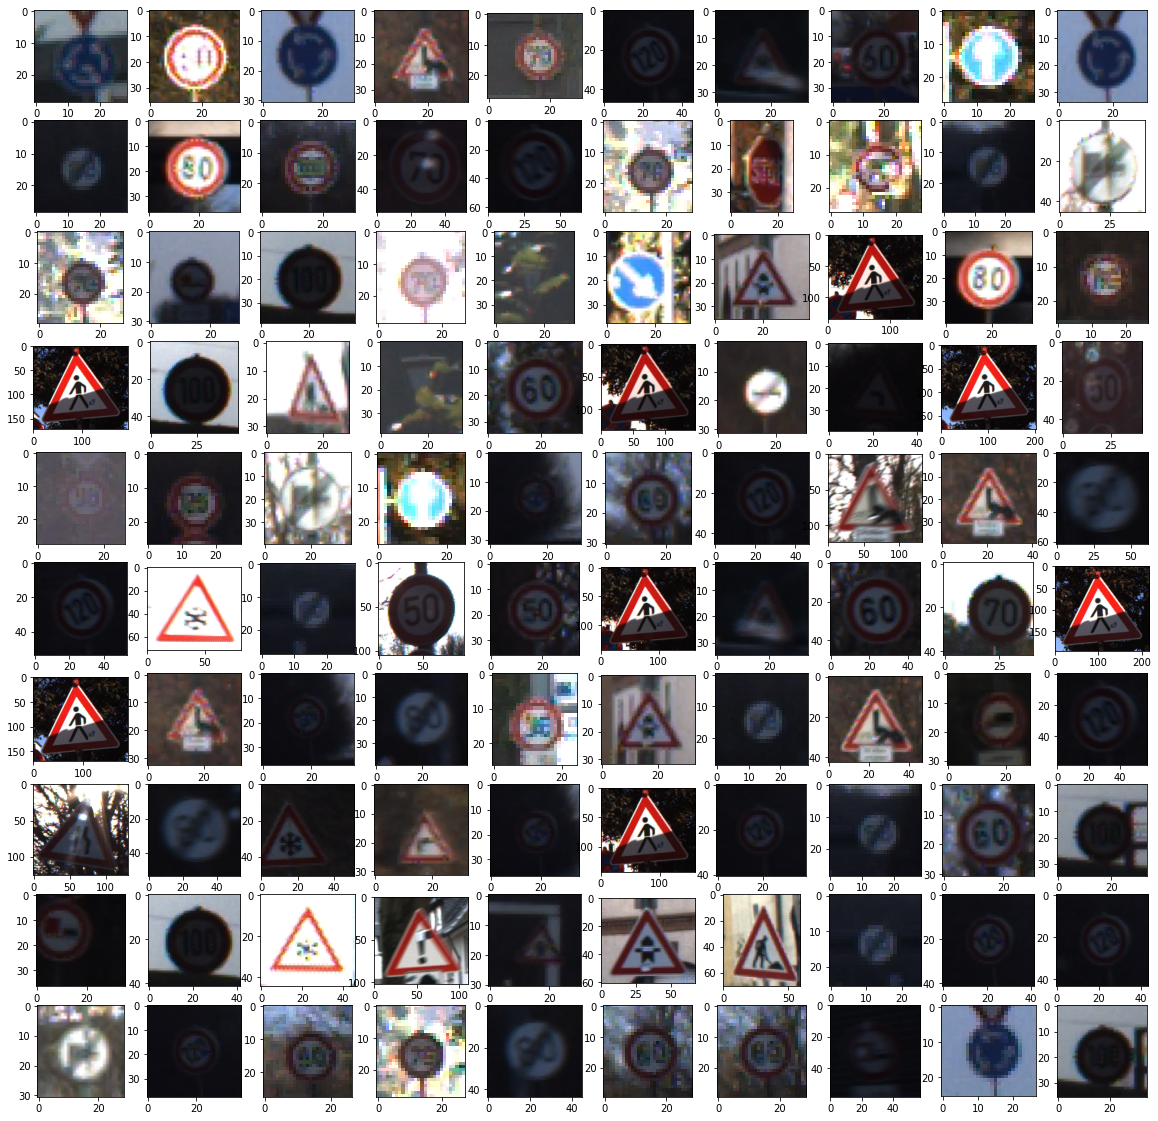

In [58]:
#Plotting some misclassified images
test_path = "/content/Data/"
fig, ax = plt.subplots(10, 10)
fig.set_size_inches((20, 20))
random_100_misclassified = random.sample(misclassified_images, 100)
for i in range(10) :
  for j in range(10) :
    im_path = test_path + random_100_misclassified[10*i + j]
    im = img.imread(im_path)
    ax[i][j].imshow(im)
plt.show()

## Observation :


*   Less than 2.5% of the images are misclassified.
*   Most of the misclassified images are very much small in dimension and are very much out of focus.
*   Some of them are not even in frame.
*   Many of them cannot be recognized even by humans

